In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
#sns.set_style("darkgrid")
#sns.set_context("poster")
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import copy

import matplotlib.ticker as mticker

import matplotlib.colors as mcolors
#palette = list(mcolors.TABLEAU_COLORS.keys())
#palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [2]:
# CAA was reconstituted in 400uL instead of 500uL
# CAA peak will then be 5/4 times what it should be
## RR will then be 4/5 of what it should be
# Correction factor: 5/4

def RR2Asp(RR):
    return(54.611* ((RR * 5/4)**1.0578))
def RR2Asn(RR):
    return(60.033* ((RR * 5/4)**0.9177))

In [3]:
### Read measurements

annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('Met-Asp-temporal.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['Response Ratio']) != 0:
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = metab_dict_mes[k]['Sample ID']
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['Dilution_factor']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Flag Details'], axis=1)

In [4]:
metab_dict_mes['Uridine neg']

,Compound,RT,Sample ID,Response,Formula,Response Ratio,Sample_name,Metformin,Dilution_factor,Proliferation_rate,Cell_line,Salvage_mix,Time
0,Uridine neg,6.17,TC01,35.72,C9H12N2O6,0.893,TC01,15,0.025,NaN,H1299,Yes,0
1,Uridine neg,6.17,TC02,35.64,C9H12N2O6,0.891,TC02,15,0.025,NaN,H1299,Yes,0
2,Uridine neg,6.17,TC03,37.64,C9H12N2O6,0.941,TC03,15,0.025,NaN,H1299,Yes,0
3,Uridine neg,6.17,TC04,31.04,C9H12N2O6,0.776,TC04,15,0.025,NaN,H1299,Yes,1
4,Uridine neg,6.17,TC05,36.16,C9H12N2O6,0.904,TC05,15,0.025,NaN,H1299,Yes,1
5,Uridine neg,6.17,TC06,32.20,C9H12N2O6,0.805,TC06,15,0.025,NaN,H1299,Yes,1
6,Uridine neg,6.17,TC07,26.64,C9H12N2O6,0.666,TC07,15,0.025,NaN,H1299,Yes,2
7,Uridine neg,6.17,TC08,28.60,C9H12N2O6,0.715,TC08,15,0.025,NaN,H1299,Yes,2
8,Uridine neg,6.17,TC09,28.72,C9H12N2O6,0.718,TC09,15,0.025,NaN,H1299,Yes,2
9,Uridine neg,6.17,TC10,25.96,C9H12N2O6,0.649,TC10,15,0.025,NaN,H1299,Yes,4


In [5]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']
    
    if 'Aspartate' in nam:
        df['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['Dilution_factor'].values
    elif 'Asparagine' in nam:
        df['Asparagine conc'] = RR2Asn(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['Dilution_factor'].values

In [6]:
df['NAD-NADH'] = (df['NAD pos'] / df['NADH neg']).replace(np.inf, np.nan)
df['GSH-GSSG'] = (df['Glutathione pos'] / df['Glutathione disulfide pos']).replace(np.inf, np.nan)

#df['Aspartate conc'] = RR2Asp(df['Aspartate neg'].values) / df['Dilution_factor'].values
#df['Asparagine conc'] = RR2Asn(df['Asparagine pos'].values) / df['Dilution_factor'].values

In [7]:
# Normalize metabolites except Asp:
df_norm = copy.deepcopy(df)
mask0 = df_norm['Time'] == 0
for col in df.columns:
    if col == 'Aspartate conc':
        continue
    if 'neg' in col or 'pos' in col or 'conc' in col or 'NAD-NADH' in col:
        df_norm.loc[:, col] = df_norm[col].values / np.mean(df_norm.loc[mask0, col])

In [8]:
df_mean = df.groupby(['Time']).mean().reset_index()
df_stdev = df.groupby(['Time']).std().reset_index()

df_norm_mean = df_norm.groupby(['Time']).mean().reset_index()
df_norm_stdev = df_norm.groupby(['Time']).std().reset_index()

In [9]:
df_mean['Asparagine conc']

0    2061.118606
1    2106.562486
2    1860.999423
3    2070.449564
4    2304.729349
5    2410.301400
6    2376.515706
Name: Asparagine conc, dtype: float64

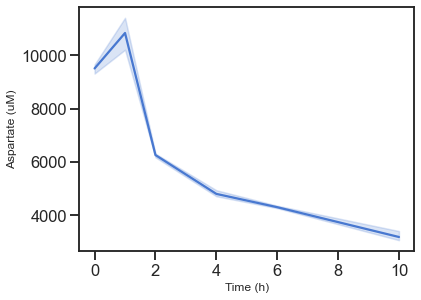

In [12]:
### Aspartate as a function of time ###

pdf = matplotlib.backends.backend_pdf.PdfPages("time_vs_Asp.pdf")
fig = plt.figure(figsize=(6, 4.5))

# Not using last timepoint as this had media depletion
# See Tuesday 04/27/21
mask = (df['Time'] < 20) 
g = sns.lineplot(data=df[mask], x='Time', y='Aspartate conc', markers=True, dashes=False)
#g.set(yscale="log");

plt.xlabel('Time (h)', size=12);
plt.ylabel('Aspartate (uM)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

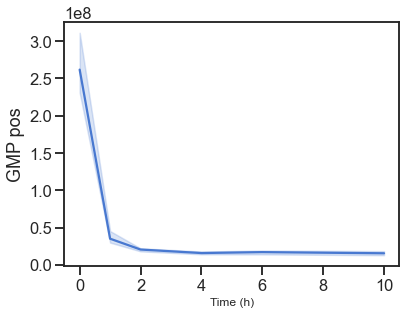

In [22]:
### Arginine as a function of time ###

#pdf = matplotlib.backends.backend_pdf.PdfPages("time_vs_Asp.pdf")
fig = plt.figure(figsize=(6, 4.5))

# Not using last timepoint as this had media depletion
# See Tuesday 04/27/21
mask = (df['Time'] < 20) 
g = sns.lineplot(data=df[mask], x='Time', y='GMP pos', markers=True, dashes=False)
#g.set(yscale="log");

plt.xlabel('Time (h)', size=12);
#plt.ylabel('Arginine', size=12);

#pdf.savefig(fig)
#plt.show(fig)
#plt.close(fig)
#pdf.close()

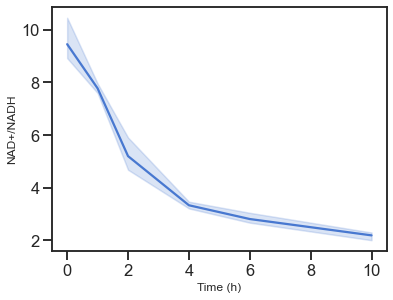

In [13]:
### NAD/NADH ratio as a function of Metformin ###

pdf = matplotlib.backends.backend_pdf.PdfPages("time_vs_NAD-NADH.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask = (df['Time'] < 20)
g = sns.lineplot(data=df[mask], x='Time', y='NAD-NADH', markers=True, dashes=False)
#g.set(xscale="log");

plt.ylabel('NAD+/NADH', size=12);
plt.xlabel('Time (h)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

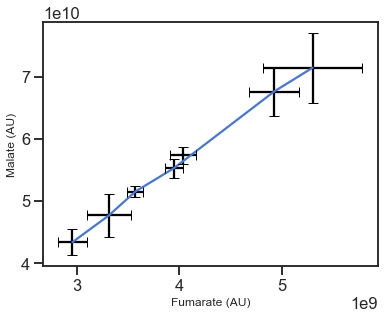

In [14]:
### Malate as a function of Fumarate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Fum_vs_Mal_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask = (df_mean['Time'] < 20)
g = sns.lineplot(data=df_mean[mask], y='Malate neg', x='Fumarate neg', markers=True, dashes=False)

g.errorbar(y=df_mean['Malate neg'].values, x=df_mean['Fumarate neg'].values, xerr=df_stdev['Fumarate neg'].values, yerr=df_stdev['Malate neg'].values, fmt='none', color='black', capsize=5)

plt.ylabel('Malate (AU)', size=12);
plt.xlabel('Fumarate (AU)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

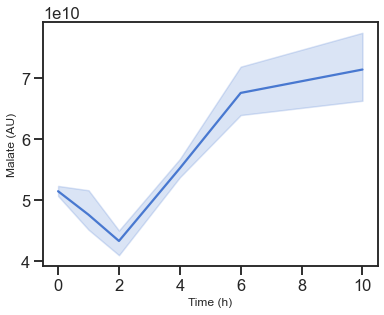

In [15]:
### Malate as a function of NAD/NADH ###

pdf = matplotlib.backends.backend_pdf.PdfPages("time_vs_Mal.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask = (df['Time'] < 20)
g = sns.lineplot(data=df[mask], y='Malate neg', x='Time', markers=True, dashes=False)

#g.errorbar(y=df_mean[mask1]['Malate neg'].values, x=df_mean[mask1]['NAD-NADH'].values, xerr=df_stdev[mask1]['NAD-NADH'].values, yerr=df_stdev[mask1]['Malate neg'].values, fmt='none', color='black', capsize=5)

plt.ylabel('Malate (AU)', size=12);
plt.xlabel('Time (h)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

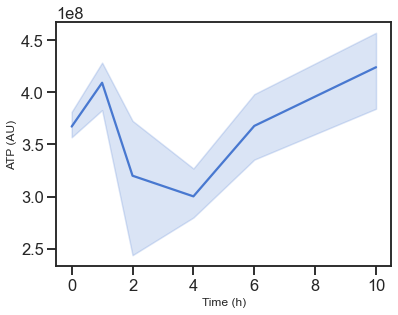

In [10]:
### ATP as a function of NAD/NADH ###

pdf = matplotlib.backends.backend_pdf.PdfPages("time_vs_ATP.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask = (df['Time'] < 20)
g = sns.lineplot(data=df[mask], y='ATP pos', x='Time', markers=True, dashes=False)

#g.errorbar(y=df_mean[mask1]['Malate neg'].values, x=df_mean[mask1]['NAD-NADH'].values, xerr=df_stdev[mask1]['NAD-NADH'].values, yerr=df_stdev[mask1]['Malate neg'].values, fmt='none', color='black', capsize=5)

plt.ylabel('ATP (AU)', size=12);
plt.xlabel('Time (h)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

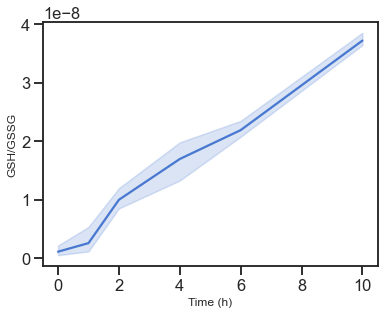

In [16]:
### GSH/GSSH as a function of NAD/NADH ###

pdf = matplotlib.backends.backend_pdf.PdfPages("time_vs_GSH-GSSG.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask = (df['Time'] < 20)
g = sns.lineplot(data=df[mask], y='GSH-GSSG', x='Time', markers=True, dashes=False)

#g.errorbar(y=df_mean[mask1]['Malate neg'].values, x=df_mean[mask1]['NAD-NADH'].values, xerr=df_stdev[mask1]['NAD-NADH'].values, yerr=df_stdev[mask1]['Malate neg'].values, fmt='none', color='black', capsize=5)

plt.ylabel('GSH/GSSG', size=12);
plt.xlabel('Time (h)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

In [17]:
# Prepare for plotting:
df_mean_melt = pd.melt(df_norm_mean, id_vars=['Time', 'Proliferation_rate', 'Aspartate conc'], var_name='Metabolite', value_name='value')
df_mean_melt['Metabolite'] = [m[:-4] if m[-3:] == 'neg' or m[-3:] == 'pos' else m for m in df_mean_melt['Metabolite'].values]

df_stdev_melt = pd.melt(df_norm_stdev, id_vars=['Time', 'Proliferation_rate', 'Aspartate conc'], var_name='Metabolite', value_name='value')
df_stdev_melt['Metabolite'] = [m[:-4] if m[-3:] == 'neg' or m[-3:] == 'pos' else m for m in df_stdev_melt['Metabolite'].values]

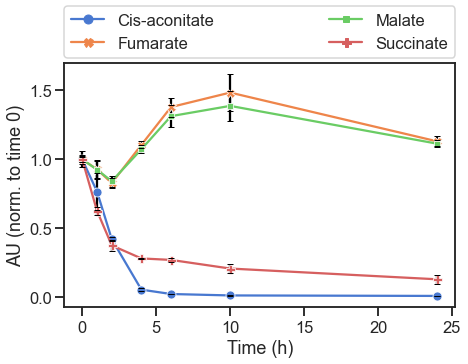

In [24]:

#pdf = matplotlib.backends.backend_pdf.PdfPages("DHODH_vs_Asp.pdf")
fig = plt.figure(figsize=(7, 4.5))
metab_list = ['Succinate', 'Malate', 'Cis-aconitate', 'Fumarate']
mask = df_mean_melt['Metabolite'].isin(metab_list)
g1 = sns.lineplot(data=df_mean_melt[mask], y='value', x='Time', markers=True, dashes=False, hue='Metabolite', style='Metabolite')

g1.errorbar(y=df_mean_melt[mask]['value'].values, x=df_mean_melt[mask]['Time'].values, yerr=df_stdev_melt[mask]['value'].values, fmt='none', color='black', capsize=3)
#g1.set(xscale="log");
g1.set(xlabel='Time (h)', ylabel='AU (norm. to time 0)')

g1.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

#pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
#pdf.close()

In [57]:
# Prepare for plotting:
df_melt = pd.melt(df_norm, id_vars=['Time', 'Proliferation_rate', 'Aspartate conc'], var_name='Metabolite', value_name='value')
df_melt['Metabolite'] = [m[:-4] if m[-3:] == 'neg' or m[-3:] == 'pos' else m for m in df_melt['Metabolite'].values]


/Users/krdav/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


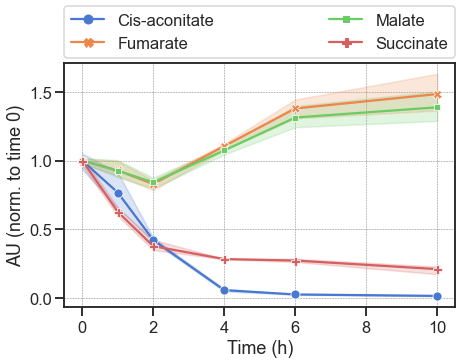

In [67]:

#pdf = matplotlib.backends.backend_pdf.PdfPages("DHODH_vs_Asp.pdf")
fig = plt.figure(figsize=(7, 4.5))
metab_list = ['Succinate', 'Malate', 'Cis-aconitate', 'Fumarate']
mask = (df_melt['Metabolite'].isin(metab_list)) & (df_melt['Time'] < 20)
df_melt_sele = df_melt[mask]
df_melt_sele.loc[:, 'value'] = pd.to_numeric(df_melt_sele['value'])
g1 = sns.lineplot(data=df_melt_sele, y='value', x='Time', markers=True, dashes=False, hue='Metabolite', style='Metabolite')
g1.set(xlabel='Time (h)', ylabel='AU (norm. to time 0)')
g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
g1.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

#pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
#pdf.close()

/Users/krdav/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


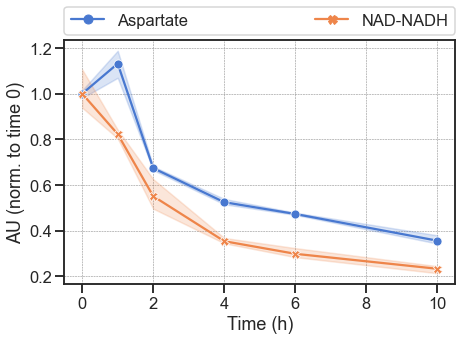

In [66]:
#pdf = matplotlib.backends.backend_pdf.PdfPages("DHODH_vs_Asp.pdf")
fig = plt.figure(figsize=(7, 4.5))
metab_list = ['Aspartate', 'NAD-NADH']
mask = (df_melt['Metabolite'].isin(metab_list)) & (df_melt['Time'] < 20)
df_melt_sele = df_melt[mask]
df_melt_sele.loc[:, 'value'] = pd.to_numeric(df_melt_sele['value'])
g1 = sns.lineplot(data=df_melt_sele, y='value', x='Time', markers=True, dashes=False, hue='Metabolite', style='Metabolite')
g1.set(xlabel='Time (h)', ylabel='AU (norm. to time 0)')
g1.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)



#pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
#pdf.close()

/Users/krdav/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/krdav/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


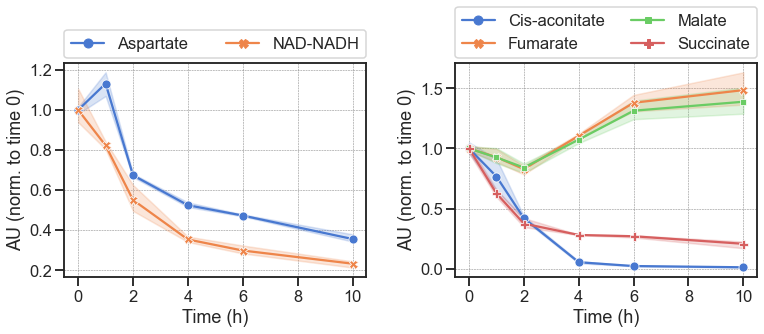

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), gridspec_kw={'width_ratios': [1, 1]})


metab_list = ['Aspartate', 'NAD-NADH']
mask = (df_melt['Metabolite'].isin(metab_list)) & (df_melt['Time'] < 20)
df_melt_sele = df_melt[mask]
df_melt_sele.loc[:, 'value'] = pd.to_numeric(df_melt_sele['value'])
g1 = sns.lineplot(ax=ax1, data=df_melt_sele, y='value', x='Time', markers=True, dashes=False, hue='Metabolite', style='Metabolite')
g1.set(xlabel='Time (h)', ylabel='AU (norm. to time 0)')
g1.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)





metab_list = ['Succinate', 'Malate', 'Cis-aconitate', 'Fumarate']
mask = (df_melt['Metabolite'].isin(metab_list)) & (df_melt['Time'] < 20)
df_melt_sele = df_melt[mask]
df_melt_sele.loc[:, 'value'] = pd.to_numeric(df_melt_sele['value'])
g2 = sns.lineplot(ax=ax2, data=df_melt_sele, y='value', x='Time', markers=True, dashes=False, hue='Metabolite', style='Metabolite')
g2.set(xlabel='Time (h)', ylabel='AU (norm. to time 0)')
g2.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
g2.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)



plt.tight_layout()
fig.savefig('combined-ETCinhib-time.pdf')

In [77]:
df_slice = df_mean.loc[:, ['Time', 'Aspartate conc', 'Proline pos', 'Serine neg', 'Glutamine pos', 'Glutamate neg', 'Ornithine pos']]

df_slice = df_slice.rename(columns={'Proline pos': 'Proline', 'Serine neg': 'Serine', 'Glutamine pos': 'Glutamine', 'Glutamate neg': 'Glutamate', 'Ornithine pos': 'Ornithine'})

In [78]:
norm_list = ['Proline', 'Serine', 'Glutamine', 'Glutamate', 'Ornithine']
for metab in norm_list:
    alen = len(df_slice[metab].values)
    norm = df_slice[metab].values[0]
    df_slice[metab] = df_slice[metab].values / norm

df_slice = pd.melt(df_slice, id_vars=['Time', 'Aspartate conc'], value_vars=norm_list, var_name='Metabolite', value_name='value')

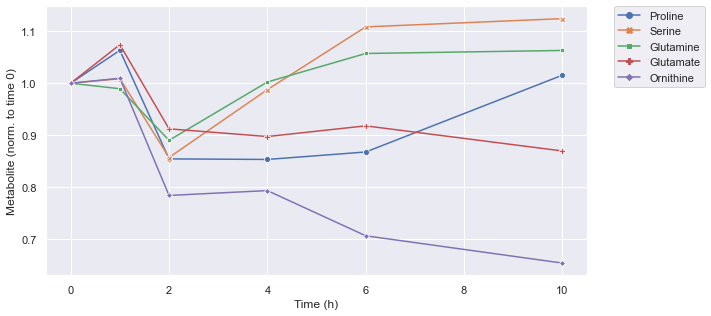

In [81]:
### Amino acids as a function of aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("time_vs_AA.pdf")
fig = plt.figure(figsize=(10, 4.5))
mask = (df_slice['Time'] < 20)
g = sns.lineplot(data=df_slice[mask], y='value', x='Time', markers=True, dashes=False, hue='Metabolite', style='Metabolite')


plt.ylabel('Metabolite (norm. to time 0)', size=12);
plt.xlabel('Time (h)', size=12);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()